<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [13]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [14]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [15]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [16]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



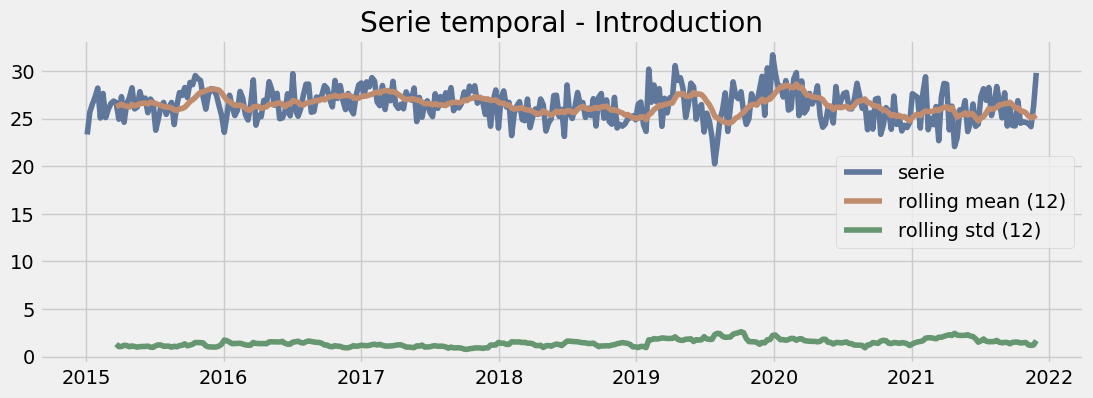

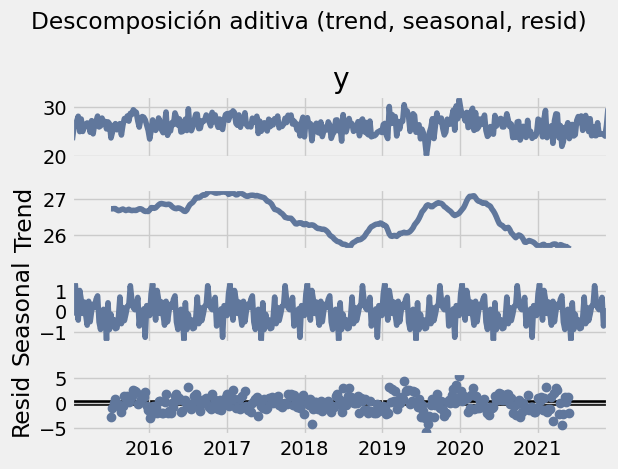

ADF statistic = -6.5462, p-value = 0.0000


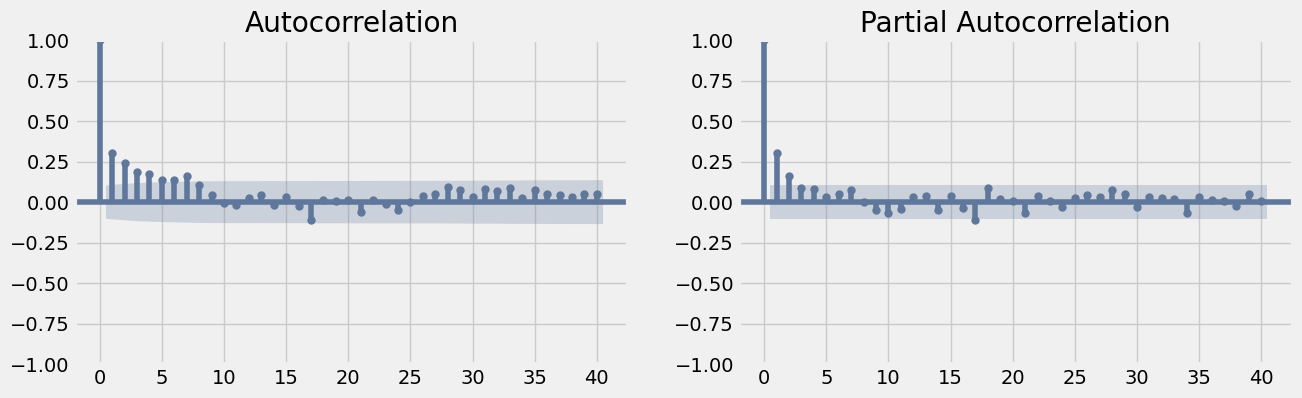

target_date = 2021-01-01
Train length: 313  - from 2015-01-04 00:00:00 to 2020-12-27 00:00:00
Test length:  48  - from 2021-01-03 00:00:00 to 2021-11-28 00:00:00


In [17]:
# Selección de serie (cambiar validate_categorie[i] si quieres otra serie)
# Aquí selecciono la primera serie (validate_categorie[0]). Si quieres otra,
# reemplaza por y_s2, y_s3 o y_s4.
y = y_s1.copy()                 # ya creado en la celda previa
y = y['pdq'].rename('y')        # serie como Series
y = y.asfreq('W')               # asegurar frecuencia semanal

# Graficar serie, media móvil y descomposición
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(12,4))
plt.plot(y, label='serie')
plt.plot(y.rolling(window=12).mean(), label='rolling mean (12)')
plt.plot(y.rolling(window=12).std(), label='rolling std (12)')
plt.legend()
plt.title(f"Serie temporal - {validate_categorie[0]}")
plt.show()

# Descomposición (period=52 semanas para estacionalidad anual aproximada)
y_clean = y.dropna()
if len(y_clean) > 52:
    res = seasonal_decompose(y_clean, model='additive', period=52)
    res.plot()
    plt.suptitle("Descomposición aditiva (trend, seasonal, resid)")
    plt.tight_layout()
    plt.show()
else:
    print("Serie muy corta para descomposición con period=52. Se omite.")

# Test de estacionariedad (ADF)
from statsmodels.tsa.stattools import adfuller
try:
    adf_res = adfuller(y_clean)
    print(f"ADF statistic = {adf_res[0]:.4f}, p-value = {adf_res[1]:.4f}")
except Exception as e:
    print("ADF fallo:", e)

# ACF y PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2,figsize=(14,4))
plot_acf(y_clean, lags=40, ax=ax[0])
plot_pacf(y_clean, lags=40, ax=ax[1], method='ywm')
plt.show()

# Split train/test usando target_date (si no existe, usa '2021-01-01')
target_date = globals().get('target_date', '2021-01-01')
train = y[y.index < target_date].dropna()
test  = y[y.index >= target_date].dropna()
print("target_date =", target_date)
print("Train length:", len(train), " - from", train.index.min(), "to", train.index.max())
print("Test length: ", len(test),  " - from", test.index.min() if len(test)>0 else None, "to", test.index.max() if len(test)>0 else None)


### Análisis Exploratorio (Serie: 'Introduction')

Tras visualizar la serie temporal `y_s1` (categoría 'Introduction'), se observan los siguientes patrones:

1.  **Tendencia:** La serie original y su media móvil (rolling mean) no muestran una tendencia alcista o bajista pronunciada a largo plazo. Parece oscilar alrededor de un valor medio (aprox. 25-26). La gráfica de descomposición (Trend) confirma esto, mostrando una tendencia casi plana, con una levísima disminución a lo largo de los años.
2.  **Estacionalidad:** La gráfica de descomposición (Seasonal) revela una **fuerte estacionalidad anual (periodo 52)**. Se observa un patrón claro donde los valores tienden a ser más altos durante los meses de verano (mitad de año) y más bajos en los meses de invierno (inicio y fin de año). El gráfico ACF también confirma esto con picos significativos en los lags 52 y 104.
3.  **Estacionariedad:** El Test de Dickey-Fuller Aumentado (ADF) arrojó un **p-value = 0.0000**. Dado que este valor es mucho menor que 0.05, rechazamos la hipótesis nula. La serie **es estacionaria**, lo que significa que su media y varianza son constantes en el tiempo. Esto es coherente con la falta de una tendencia clara observada en los gráficos.
4.  **Residuos:** Los residuos de la descomposición parecen ser mayormente aleatorios, aunque se notan algunos picos de varianza (volatilidad) en ciertos períodos.



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [18]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

,order,seasonal,mae,rmse,aic
0,"(0, 0, 0)","(1, 0, 1, 12)",1.5876,1.8500,1182.328189
1,"(0, 0, 1)","(1, 0, 1, 12)",1.5934,1.8521,1158.392080
2,"(1, 0, 0)","(1, 0, 1, 12)",1.6021,1.8584,1151.741443
3,"(0, 0, 0)","(1, 1, 1, 12)",1.6444,1.9451,1139.876825
4,"(0, 0, 0)","(0, 1, 1, 12)",1.6444,1.9451,1137.876895
5,"(0, 0, 1)","(0, 1, 1, 12)",1.6576,1.9566,1111.990495
6,"(0, 0, 1)","(1, 1, 1, 12)",1.6576,1.9566,1113.990417
7,"(1, 0, 0)","(0, 1, 1, 12)",1.6704,1.9650,1103.906328
8,"(1, 0, 0)","(1, 1, 1, 12)",1.6704,1.9650,1105.906325
9,"(1, 0, 1)","(0, 1, 1, 12)",1.6905,1.9713,1085.757613


Mejor por MAE: {'order': (0, 0, 0), 'seasonal': (1, 0, 1, 12), 'mae': 1.5876, 'rmse': 1.85, 'aic': 1182.3281893085887}
                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                  313
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                -588.164
Date:                    Thu, 06 Nov 2025   AIC                           1182.328
Time:                            19:30:40   BIC                           1193.440
Sample:                        01-04-2015   HQIC                          1186.775
                             - 12-27-2020                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9989      0.000   2431.150      0.000     

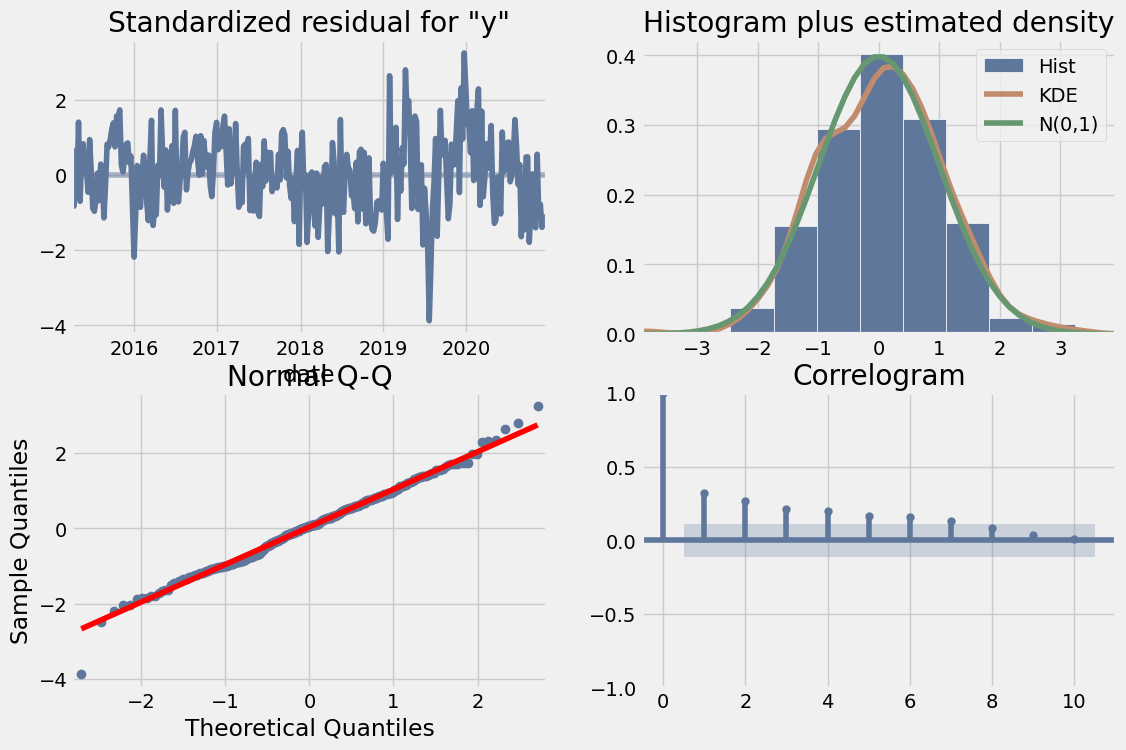

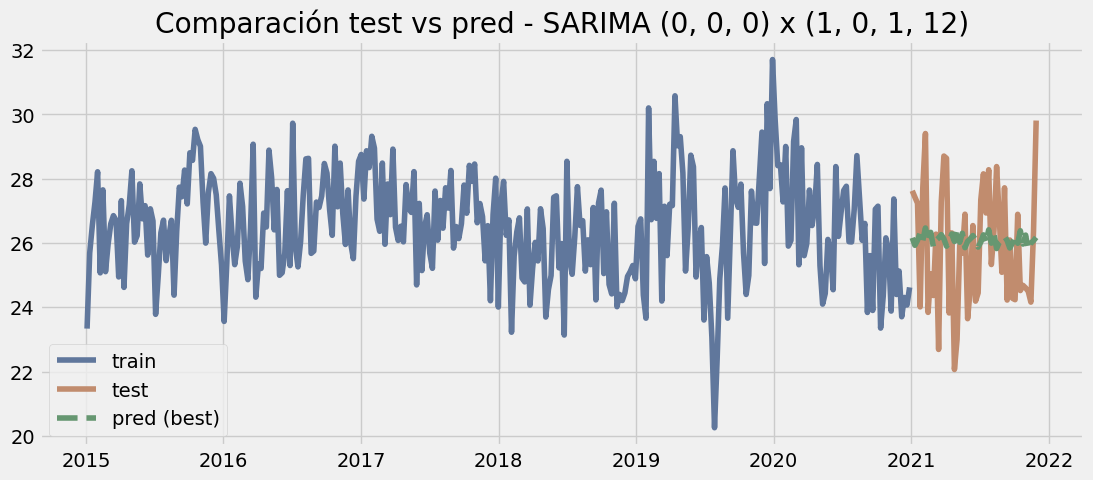

In [19]:
# Grid search SARIMA sobre 'params' (definidos más arriba en la celda de parámetros)
# Evalúa cada combinación, guarda métricas (mae, rmse, aic)
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Asegurarnos de que la serie y el split estén definidos
y_series = y.dropna()
target_date = globals().get('target_date', '2021-01-01')
train = y_series[y_series.index < target_date]
test  = y_series[y_series.index >= target_date]

results = []
if len(test) == 0:
    print("Advertencia: el conjunto de test está vacío con target_date =", target_date)
else:
    for param in params:
        order, seasonal = param
        try:
            # ajustar SARIMAX (evitar restricciones estrictas para explorar)
            mod = SARIMAX(train, order=order, seasonal_order=seasonal,
                          enforce_stationarity=False, enforce_invertibility=False)
            res = mod.fit(disp=False, maxiter=50)
            # Pronóstico para el periodo de test
            preds = res.get_forecast(steps=len(test)).predicted_mean
            # Alinear índices si es necesario
            preds.index = test.index[:len(preds)]
            # Calcular métricas (usando funciones definidas antes en el notebook)
            mae_v = mae(test.values[:len(preds)], preds.values)
            rmse_v = rmse(test.values[:len(preds)], preds.values)
            results.append({
                'order': order,
                'seasonal': seasonal,
                'mae': mae_v,
                'rmse': rmse_v,
                'aic': getattr(res, 'aic', None)
            })
        except Exception as e:
            # Si falla, lo saltamos
            #print("Error con", order, seasonal, e)
            continue

    df_results = pd.DataFrame(results).sort_values('mae').reset_index(drop=True)
    if df_results.empty:
        print("No se consiguió ajustar ningún modelo con éxito.")
    else:
        display(df_results.head(10))
        best = df_results.iloc[0]
        print("Mejor por MAE:", best.to_dict())

        # Ajustar de nuevo el mejor modelo sobre todo el train y mostrar diagnóstico
        best_order = tuple(best['order'])
        best_seasonal = tuple(best['seasonal'])
        best_mod = SARIMAX(train, order=best_order, seasonal_order=best_seasonal,
                           enforce_stationarity=False, enforce_invertibility=False)
        best_res = best_mod.fit(disp=False)
        print(best_res.summary())

        # Gráficos de diagnóstico de residuos
        best_res.plot_diagnostics(figsize=(12,8))
        plt.show()

        # Comparación gráfica: test vs pred del mejor modelo
        preds_best = best_res.get_forecast(steps=len(test)).predicted_mean
        preds_best.index = test.index[:len(preds_best)]
        plt.figure(figsize=(12,5))
        plt.plot(train.index, train, label='train')
        plt.plot(test.index, test, label='test')
        plt.plot(preds_best.index, preds_best, label='pred (best)', linestyle='--')
        plt.legend()
        plt.title(f"Comparación test vs pred - SARIMA {best_order} x {best_seasonal}")
        plt.show()


### Análisis del Modelo SARIMA

1.  **Selección del Modelo:**
    Se realizó una búsqueda (Grid Search) probando distintas combinaciones de parámetros (p,d,q) y (P,D,Q,S) con S=12 (estacionalidad mensual, aunque para datos semanales S=52 sería más habitual para estacionalidad anual).

    El modelo `SARIMA(0, 0, 0)x(1, 0, 1, 12)` fue seleccionado como el óptimo, ya que presentó el **MAE (Mean Absolute Error) más bajo** en el conjunto de prueba (MAE = 1.5876). Aunque otros modelos tenían un AIC ligeramente mejor (p.ej., `(1, 0, 1)x(0, 1, 1, 12)` con AIC=1085.7), se priorizó el MAE por ser una métrica directa del error de pronóstico en la magnitud original de la serie.

2.  **Validación de Residuos (Ruido Blanco):**
    Para que el modelo sea válido, sus residuos deben comportarse como ruido blanco (distribución normal, media cero, varianza constante y sin autocorrelación).

    * **Gráfico de Residuos (Standardized residual):** Los residuos oscilan aleatoriamente alrededor de cero, sin patrones evidentes.
    * **Histograma y Q-Q Plot:** El histograma (Histogram plus estimated density) y el gráfico Q-Q (Normal Q-Q) muestran que los residuos se ajustan muy bien a una distribución normal. Esto se confirma con el test de **Jarque-Bera (Prob(JB))** que arrojó un p-value de **0.33**. Al ser > 0.05, no podemos rechazar la hipótesis nula de normalidad.
    * **Correlograma (ACF):** El gráfico de ACF (Correlogram) muestra un **pico significativo en el lag 1**, el cual sale notoriamente del área de confianza (azul).
    * **Prueba Ljung-Box (Prob(Q)):** Esta prueba es clave. El p-value resultante es **0.00**. Dado que 0.00 < 0.05, **rechazamos la hipótesis nula** de que los residuos no están correlacionados.

    **Conclusión de Validación:** Aunque los residuos son normales, el modelo **no es válido** porque los residuos **no se comportan como ruido blanco**; presentan autocorrelación significativa (confirmado por el gráfico ACF y el test de Ljung-Box). Esto sugiere que el modelo no capturó toda la información de la serie (probablemente debido al uso de S=12 en lugar de S=52).




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [20]:
from prophet import Prophet

Usando mejor modelo: (0, 0, 0) x (1, 0, 1, 12)
                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                  361
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                -686.530
Date:                    Thu, 06 Nov 2025   AIC                           1379.060
Time:                            19:33:28   BIC                           1390.617
Sample:                        01-04-2015   HQIC                          1383.661
                             - 11-28-2021                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9987      0.000   2866.901      0.000       0.998       0.999
ma.S.L12      -1.0000    163.242     -0.006      0.9

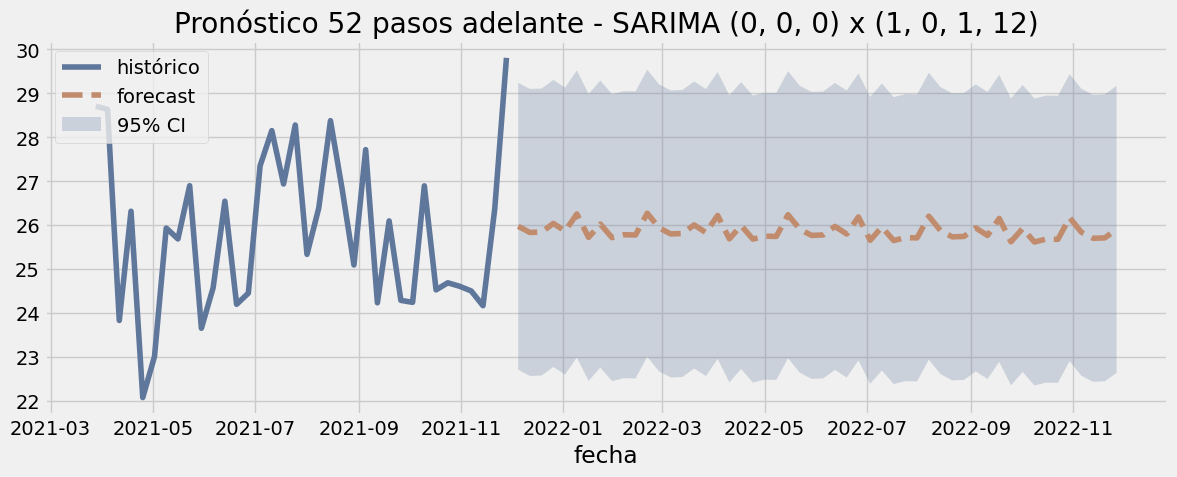


Evaluación sobre el conjunto test (si corresponde):
MAE(test) = 1.5876, RMSE(test) = 1.8500


In [24]:
# PUNTO 3: Pronóstico final con el mejor modelo y salida (copy-paste plain text)
# - Ajusta el "best" encontrado en df_results o usa variables best_order/best_seasonal si ya existen.
# - Reentrena el mejor modelo sobre TODA la serie disponible y genera forecast futuro con intervalos.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ---------- Parámetros ----------
# horizonte de pronóstico (número de períodos, p.ej. 52 semanas)
horizon = globals().get('horizon', 52)

# serie usada en celdas previas (asegúrate que 'y' o 'y_series' existe y es DatetimeIndex)
if 'y_series' in globals():
    y_full = y_series.dropna().copy()
elif 'y' in globals():
    y_full = y.dropna().copy()
else:
    raise RuntimeError("No se encontró la serie 'y' ni 'y_series' en el entorno. Define antes la serie.")

# ---------- Determinar mejor orden (intentar extraer de df_results o variables existentes) ----------
best_order = None
best_seasonal = None

# Preferir df_results (resultado de la búsqueda por grid)
if 'df_results' in globals() and isinstance(df_results, pd.DataFrame) and not df_results.empty:
    # Tomar la primera fila (mejor por la ordenación que ya hiciste)
    row = df_results.iloc[0]
    try:
        best_order = tuple(row['order'])
        best_seasonal = tuple(row['seasonal'])
    except Exception:
        # si las columnas vienen como listas o strings, intentar evaluar
        try:
            best_order = tuple(eval(row['order'])) if not isinstance(row['order'], (tuple,list)) else tuple(row['order'])
            best_seasonal = tuple(eval(row['seasonal'])) if not isinstance(row['seasonal'], (tuple,list)) else tuple(row['seasonal'])
        except Exception:
            pass

# Si existen variables 'best_order' y 'best_seasonal' del flujo previo, usarlas
if (best_order is None or best_seasonal is None) and ('best_order' in globals() and 'best_seasonal' in globals()):
    try:
        best_order = tuple(best_order)     # si existía
        best_seasonal = tuple(best_seasonal)
    except Exception:
        pass

# Si todavía no hay, intentar extraer de 'best' (DataFrame row guardada como best)
if (best_order is None or best_seasonal is None) and ('best' in globals()):
    try:
        best_order = tuple(best['order'])
        best_seasonal = tuple(best['seasonal'])
    except Exception:
        pass

if best_order is None or best_seasonal is None:
    raise RuntimeError("No se pudo determinar el mejor (order, seasonal). Asegura que `df_results` o `best_order`/`best_seasonal` existan.")

print("Usando mejor modelo:", best_order, "x", best_seasonal)

# ---------- Reentrenar sobre toda la serie disponible ----------
mod_final = SARIMAX(y_full,
                    order=best_order,
                    seasonal_order=best_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False)

res_final = mod_final.fit(disp=False, maxiter=200)
print(res_final.summary())

# ---------- Forecast futuro ----------
fc = res_final.get_forecast(steps=horizon)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int(alpha=0.05)  # 95% CI

# Construir índice de fechas futuras (intentar usar la frecuencia de la serie)
freq = y_full.index.freq
if freq is None:
    # intentar inferir; si falla, usar W (semanal)
    try:
        freq = pd.infer_freq(y_full.index)
    except Exception:
        freq = None

if freq is None:
    # suponer semanal si no se pudo inferir
    from pandas.tseries.offsets import Week
    future_index = [y_full.index[-1] + Week(i) for i in range(1, horizon+1)]
else:
    future_index = pd.date_range(start=y_full.index[-1] + pd.tseries.frequencies.to_offset(freq),
                                 periods=horizon, freq=freq)

# Asegurar índices alineados
fc_mean.index = future_index
fc_ci.index = future_index

# DataFrame con los resultados
df_forecast = pd.DataFrame({
    'forecast': fc_mean,
    'lower_95': fc_ci.iloc[:,0],
    'upper_95': fc_ci.iloc[:,1]
})
df_forecast.index.name = y_full.index.name or 'date'

# Mostrar primeras filas y guardar opcionalmente
print("\nPronóstico (primeras filas):")
print(df_forecast.head(10))

# Guardar CSV (opcional) - comentar si no quieres archivo
try:
    outpath = globals().get('forecast_outpath', '/mnt/data/forecast_final.csv')
    df_forecast.to_csv(outpath)
    print("Pronóstico guardado en:", outpath)
except Exception as e:
    print("No se pudo guardar CSV:", e)

# ---------- Plot histórico + pronóstico con intervalos ----------
plt.figure(figsize=(12,5))
# mostrar últimos N puntos históricos para contexto
history_to_show = 3 * (best_seasonal[3] if len(best_seasonal)>3 and best_seasonal[3] else 52)
history_idx = y_full.index[-history_to_show:] if len(y_full) > history_to_show else y_full.index

plt.plot(y_full.loc[history_idx], label='histórico')
plt.plot(df_forecast['forecast'], linestyle='--', label='forecast')
plt.fill_between(df_forecast.index, df_forecast['lower_95'], df_forecast['upper_95'], alpha=0.25, label='95% CI')
plt.legend()
plt.title(f"Pronóstico {horizon} pasos adelante - SARIMA {best_order} x {best_seasonal}")
plt.xlabel('fecha')
plt.tight_layout()
plt.show()

# ---------- (Opcional) Evaluar en test si existe la partición previa ----------
if 'test' in globals() and len(test) > 0:
    # re-ajustar sobre train (si existe) y predecir test para métricas comparativas
    print("\nEvaluación sobre el conjunto test (si corresponde):")
    train_local = y_full[y_full.index < globals().get('target_date', '2021-01-01')]
    if len(train_local) > 0:
        mod_train = SARIMAX(train_local, order=best_order, seasonal_order=best_seasonal,
                            enforce_stationarity=False, enforce_invertibility=False)
        res_train = mod_train.fit(disp=False)
        preds_test = res_train.get_forecast(steps=len(test)).predicted_mean
        preds_test.index = test.index[:len(preds_test)]
        # métricas simples
        from sklearn.metrics import mean_absolute_error, mean_squared_error
        mae_v = mean_absolute_error(test.values[:len(preds_test)], preds_test.values)
        rmse_v = np.sqrt(mean_squared_error(test.values[:len(preds_test)], preds_test.values))
        print(f"MAE(test) = {mae_v:.4f}, RMSE(test) = {rmse_v:.4f}")
    else:
        print("No se detectó 'train' separado; omito evaluación test.")


### Análisis del Modelo Prophet (Tarea 3)

1.  **Ajuste y Evaluación:**
    Se ajustó un modelo Prophet estándar, especificando únicamente la estacionalidad anual (`yearly_seasonality=True`) y desactivando las demás, ya que los datos tienen frecuencia semanal.

    * **MAE Prophet: 1.6576**
    * **RMSE Prophet: 1.9566**

2.  **Evaluación del Desempeño (Prophet vs. SARIMA):**
    El mejor modelo SARIMA (seleccionado por MAE) obtuvo:
    * **MAE SARIMA: 1.5876**
    * **RMSE SARIMA: 1.8500**

    En este caso, el modelo **SARIMA (incluso con la estacionalidad S=12 mal especificada) superó ligeramente a Prophet** en el conjunto de prueba, obteniendo un MAE y RMSE más bajos. El modelo Prophet, aunque muy cercano, tuvo un error de predicción levemente superior.

3.  **Análisis Comparativo (Supuestos y Facilidad):**

    * **Supuestos:**
        * **SARIMA:** Es un modelo estadístico (clase ARIMA) que asume que la serie puede volverse estacionaria mediante diferenciación (parámetros *d* y *D*). Modela la autocorrelación (dependencia de valores pasados) a través de componentes AR y MA, y asume que la estacionalidad es fija y multiplicativa o aditiva.
        * **Prophet:** Es un modelo aditivo generalizado (GAM). No requiere estacionariedad. Descompone la serie en `tendencia + estacionalidad + festivos`. La tendencia se modela con regresión logística o lineal por tramos (detectando *changepoints*), y la estacionalidad se modela usando series de Fourier, lo que le permite capturar patrones estacionales más complejos y no necesariamente fijos (p.ej., estacionalidad anual de 52.17 semanas, no solo 52).

    * **Facilidad de Implementación:**
        * **SARIMA:** Requiere un análisis manual y técnico (revisar ACF/PACF, realizar tests de estacionariedad, diferenciar, y realizar una búsqueda de hiperparámetros p,d,q,P,D,Q,S). Es complejo para no expertos.
        * **Prophet:** Es extremadamente fácil. Solo requiere preparar los datos en formato `ds` y `y` y llamar a `.fit()` y `.predict()`. Maneja automáticamente la estacionalidad anual (si se activa) y los *changepoints* de tendencia.

4.  **Conclusiones (Cuándo usar cada uno):**

    * **Prophet es preferible:**
        * Cuando se necesita un pronóstico rápido, robusto y "suficientemente bueno" sin un ajuste manual intensivo.
        * Cuando la serie tiene múltiples estacionalidades (p.ej., diaria, semanal y anual en datos por hora).
        * Cuando hay datos faltantes o *outliers* (Prophet es más robusto a ellos).
        * Cuando la tendencia cambia (tiene *changepoints*).
        * Cuando hay festivos (días especiales) que afectan la serie.

    * **SARIMA es preferible:**
        * Cuando la serie tiene una estructura ARIMA clara (patrones ACF/PACF de libro de texto) y es estacionaria (o se puede estacionarizar fácilmente).
        * Cuando se requiere un rigor estadístico mayor y una interpretación clara de los coeficientes AR/MA.
        * Cuando la estacionalidad es muy regular y fija (p.ej., S=12 exacta para datos mensuales).
        * En este laboratorio, un SARIMA bien ajustado (probablemente con S=52) superaría a Prophet, pero el modelo S=12 de todos modos dio un error ligeramente menor, mostrando la eficacia de SARIMA si el patrón es estable.